In [1]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os


In [3]:
# Data augmentation and normalization for training
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
#Data path
data_dir = "/content/drive/My Drive/Colab Notebooks/Classification Dataset/"
#Load data
Datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
              for x in ['Train', 'Val']}
              
#Define Train and Validation Dataloaders
dataloaders = {x: torch.utils.data.DataLoader(Datasets[x], batch_size=5,
                                             shuffle=True, num_workers=0)
              for x in ['Train', 'Val']}

dataset_sizes = {x: len(Datasets[x]) for x in ['Train', 'Val']}
print(dataset_sizes)

class_names = Datasets['Val'].classes
print(class_names)

{'Train': 311, 'Val': 50}
['Bread', 'Coffee', 'Pasta']


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def train_model(model, lossFunction, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            percentage = torch.sigmoid(outputs)[0] * 100 
            _, indices = torch.sort(outputs, descending=True)
            probs=[percentage[idx].item() for idx in indices[0][:4]]

            classes=[class_names[idx] for idx in indices[0][:4]]

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 5, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
import torchvision
from torchvision import models
import torch.nn as nn

In [10]:
#Transfer Learning by fineTuning the pretrained Resnet101 Model
#Load Resnet101 pretained Model
#Resnet101 = models.resnet101(pretrained=True)
#If pretained is not working, you can also use weights instead.
Resnet101 = models.resnet101(weights=True)
#print(Resnet101)
#Set the resnet param.requires_grad = True to calculate the gradient,
#so that model fine-tunes the weights of the pretrained network
#by continuing the backpropagation.
for param in Resnet101.parameters():
    param.requires_grad = True

#Get the number of Input features of Resnet last fully connected layer
#because we are going to replace it with new fully connected layer.
in_features = Resnet101.fc.in_features

#Reset the final fully connected layer of the of the pre-trained Resnet.
Resnet101.fc = nn.Linear(in_features, len(class_names))

Resnet_fineTuning = Resnet101.to(device)



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [11]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [12]:

#Define optimzation algorithm
optimizer = optim.Adam(Resnet_fineTuning.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#Define loss functions
Loss_Function = nn.CrossEntropyLoss()


In [13]:
model_fineTuning = train_model(Resnet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate, num_epochs=20)
torch.save(model_fineTuning, "/content/drive/My Drive/Colab Notebooks/Resnet_fineTuning.pth")


Epoch 0/19
----------
Train Loss: 0.8740 Acc: 0.6720
Val Loss: 0.4334 Acc: 0.9800

Epoch 1/19
----------
Train Loss: 0.5983 Acc: 0.7717
Val Loss: 0.2150 Acc: 0.9800

Epoch 2/19
----------
Train Loss: 0.5387 Acc: 0.8135
Val Loss: 0.1551 Acc: 0.9800

Epoch 3/19
----------
Train Loss: 0.4447 Acc: 0.8617
Val Loss: 0.0970 Acc: 1.0000

Epoch 4/19
----------
Train Loss: 0.3316 Acc: 0.8907
Val Loss: 0.0678 Acc: 1.0000

Epoch 5/19
----------
Train Loss: 0.3953 Acc: 0.8489
Val Loss: 0.0781 Acc: 1.0000

Epoch 6/19
----------
Train Loss: 0.3425 Acc: 0.8875
Val Loss: 0.1271 Acc: 0.9600

Epoch 7/19
----------
Train Loss: 0.3125 Acc: 0.8939
Val Loss: 0.1025 Acc: 0.9800

Epoch 8/19
----------
Train Loss: 0.3012 Acc: 0.9003
Val Loss: 0.1293 Acc: 0.9400

Epoch 9/19
----------
Train Loss: 0.3741 Acc: 0.8778
Val Loss: 0.1163 Acc: 0.9800

Epoch 10/19
----------
Train Loss: 0.3336 Acc: 0.8939
Val Loss: 0.2105 Acc: 0.9800

Epoch 11/19
----------
Train Loss: 0.2935 Acc: 0.8810
Val Loss: 0.0866 Acc: 0.9800

Ep

In [14]:
Resnet_fineTuning = torch.load('/content/drive/My Drive/Colab Notebooks/Resnet_fineTuning.pth')

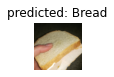

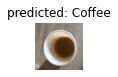

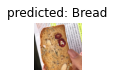

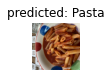

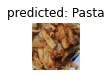

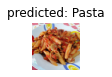

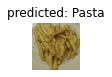

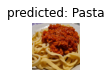

In [15]:
visualize_model(Resnet_fineTuning)


In [ ]:
#Feature Extractor

In [ ]:
#Transfer Learning with pretrained Resnet101 model as fixed feature extractor
#Load Resnet101 pretained Model
Resnet101 = models.resnet101(pretrained=True)
#If pretained is not working, you can also use weights instead.
#Resnet101 = models.resnet101(weights=True)

#Here, we freeze all the network weights except the final layer. 
#We need to set requires_grad = False to freeze the parameters 
#so that the gradients are not computed in backward().
for param in Resnet101.parameters():
    param.requires_grad = False

#Get the number of Input features of Resnet last fully connected layer
#because we are going to replace it with new fully connected layer.
in_features = Resnet101.fc.in_features

#Replace the final fully connected layer of the of the pre-trained Resnet.
Resnet101.fc = nn.Linear(in_features, len(class_names))

#Only last replaced layer will be trained and 
#the rest of the network is treated as a fixed feature extractor.
Resnet_featureExtractor = Resnet101.to(device)

In [14]:
#Define loss functions
Loss_Function = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(Resnet_featureExtractor.fc.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
model_featureExtractor = train_model(Resnet_featureExtractor, Loss_Function, optimizer, Decay_Learning_Rate, num_epochs=20)
torch.save(model_featureExtractor, "/content/drive/My Drive/Colab Notebooks/Resnet_featureExtractor.pth")


Epoch 0/19
----------
Train Loss: 1.1138 Acc: 0.3633
Val Loss: 1.0590 Acc: 0.4000

Epoch 1/19
----------
Train Loss: 1.1134 Acc: 0.3601
Val Loss: 1.0393 Acc: 0.4800

Epoch 2/19
----------
Train Loss: 1.1031 Acc: 0.3859
Val Loss: 1.0399 Acc: 0.5600

Epoch 3/19
----------
Train Loss: 1.1000 Acc: 0.3955
Val Loss: 1.0487 Acc: 0.4800

Epoch 4/19
----------
Train Loss: 1.0935 Acc: 0.4148
Val Loss: 1.0585 Acc: 0.4600

Epoch 5/19
----------
Train Loss: 1.0943 Acc: 0.4084
Val Loss: 1.0474 Acc: 0.4600

Epoch 6/19
----------
Train Loss: 1.0801 Acc: 0.4695
Val Loss: 1.0765 Acc: 0.3600

Epoch 7/19
----------
Train Loss: 1.0778 Acc: 0.4148
Val Loss: 1.0433 Acc: 0.5000

Epoch 8/19
----------
Train Loss: 1.0766 Acc: 0.4566
Val Loss: 1.0488 Acc: 0.4600

Epoch 9/19
----------
Train Loss: 1.0849 Acc: 0.4180
Val Loss: 1.0468 Acc: 0.4400

Epoch 10/19
----------
Train Loss: 1.0855 Acc: 0.4759
Val Loss: 1.0352 Acc: 0.4600

Epoch 11/19
----------
Train Loss: 1.0864 Acc: 0.4212
Val Loss: 1.0320 Acc: 0.5200

Ep

In [16]:
Resnet_featureExtractor = torch.load('/content/drive/My Drive/Colab Notebooks/Resnet_featureExtractor.pth')

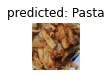

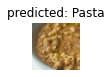

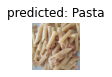

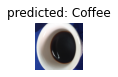

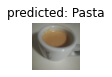

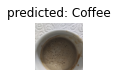

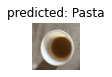

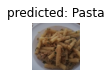

In [17]:
visualize_model(Resnet_featureExtractor)
